# CNN Transferlearning Model to predict seamounts 
Version with fine tuning of complete resnet50

## Lib import and definitions stage

In [17]:
import os
import sys

# prevent CUDA usage Warnings
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
# add path to load config for dataset import
sys.path.append(os.path.abspath("../0_Dataset"))

import config
import cv2
from collections import Counter
from datetime import datetime
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

## Load the datasets, split in train, val and test sets and nomalize values
Load into data and labels

In [18]:
# Load processed dataset
def load_data(directory, categories):
    data, labels, filenames = [], [], []
    for label, category in enumerate(categories):
        category_folder = os.path.join(directory, category)
        for file_name in os.listdir(category_folder):
            file_path = os.path.join(category_folder, file_name)
            image = cv2.imread(file_path)
            if image is not None:
                data.append(image)
                labels.append(label)
                filenames.append(file_name)
    return np.array(data), np.array(labels), np.array(filenames)

data, labels, filenames = load_data(config.DATASETS_FOLDER, config.CATEGORIES)

# Split into training, validation, and test sets
X_train, X_temp, y_train, y_temp , filenames_train, filenames_temp = train_test_split(
    data, labels, filenames, test_size=0.3, random_state=42
)
X_val, X_test, y_val, y_test, filenames_val, filenames_test = train_test_split(
    X_temp, y_temp, filenames_temp, test_size=0.5, random_state=42)

# Normalize pixel values
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

print("Datasets load, normalized and splitted")

def show_label_distribution(labels, dataset_name):
    label_counts = Counter(labels)
    print(f"Label distribution for {dataset_name} with {len(labels)} Images:")
    for label, count in label_counts.items():
        print(f"  Labels {label}: {count}")

# show some basic stats about the datasets
show_label_distribution(y_train, "Training set")
show_label_distribution(y_val, "Validation set")
show_label_distribution(y_test, "Test set")

Datasets load, normalized and splitted
Label distribution for Training set with 700 Images:
  Labels 1: 350
  Labels 0: 350
Label distribution for Validation set with 150 Images:
  Labels 0: 72
  Labels 1: 78
Label distribution for Test set with 150 Images:
  Labels 1: 72
  Labels 0: 78


## Define the CNN Model

Define and show structure

In [19]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout, Flatten, GlobalAveragePooling2D, Input

# load base model without Top Layer (different classification type)
base_model = ResNet50(weights='imagenet', include_top=False, 
                      input_shape=(config.IMAGE_SIZE[0], config.IMAGE_SIZE[1], 3))

# add top layer for binary classification
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# don't train the base model just the new top layer
base_model.trainable = False

# compile and show model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,718,913 (90.48 MB)

 Trainable params: 131,201 (512.50 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Train new toplayer first
To keep the good pretrained network but adopt the new top layer with classification, first keep the basic network fixed

In [20]:
# learn parameter
batch_size = 32
epochs = 120

# Train the model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=epochs,
    batch_size=batch_size
)

Epoch 1/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 15s 482ms/step - accuracy: 0.5173 - loss: 0.7822 - val_accuracy: 0.4800 - val_loss: 0.7087
Epoch 2/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 419ms/step - accuracy: 0.5331 - loss: 0.7105 - val_accuracy: 0.5467 - val_loss: 0.6851
Epoch 3/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 428ms/step - accuracy: 0.5815 - loss: 0.6801 - val_accuracy: 0.5133 - val_loss: 0.6808
Epoch 4/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 416ms/step - accuracy: 0.5165 - loss: 0.6862 - val_accuracy: 0.5200 - val_loss: 0.6749
Epoch 5/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 405ms/step - accuracy: 0.5827 - loss: 0.6737 - val_accuracy: 0.5133 - val_loss: 0.6697
Epoch 6/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 407ms/step - accuracy: 0.5819 - loss: 0.6665 - val_accuracy: 0.7933 - val_loss: 0.6682
Epoch 7/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 10s 454ms/step - accuracy: 0.6190 - loss: 0.6671 - val_accuracy: 0.5133 - val_loss: 0.6690
Epoch 8/120
22/22 ━━━━━━━━━━━━━━━━━━━━ 9s 408ms/step - accuracy: 0.5825 - loss: 0.6675 - val_ac

## Fine tuning

Now unfreeze the whole network and train with very low learning rate

In [21]:
# unfreeze the base model
base_model.trainable = True

# very low learning rate
model.compile(optimizer=Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy'])

# Feintuning
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=3,
    batch_size=1
)

Epoch 1/3
700/700 ━━━━━━━━━━━━━━━━━━━━ 192s 252ms/step - accuracy: 0.5064 - loss: 0.7379 - val_accuracy: 0.4733 - val_loss: 25.0863
Epoch 2/3
700/700 ━━━━━━━━━━━━━━━━━━━━ 176s 251ms/step - accuracy: 0.6113 - loss: 0.6342 - val_accuracy: 0.4867 - val_loss: 1.9941
Epoch 3/3
700/700 ━━━━━━━━━━━━━━━━━━━━ 176s 252ms/step - accuracy: 0.7334 - loss: 0.5711 - val_accuracy: 0.4933 - val_loss: 1.9422


## Model evaluation details

In [22]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
print(classification_report(y_test, y_pred, target_names=config.CATEGORIES))

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.5264 - loss: 1.8516
Test Loss: 1.7986257076263428, Test Accuracy: 0.5400000214576721
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 523ms/step
                  precision    recall  f1-score   support

   with_seamount       0.53      0.96      0.68        78
without_seamount       0.67      0.08      0.15        72

        accuracy                           0.54       150
       macro avg       0.60      0.52      0.42       150
    weighted avg       0.60      0.54      0.43       150



## Save model
Optional save your model to compare and access models later
TODO: think about to better store different learning paramater

In [17]:
# Save the model
current_datetime = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
model_filename = f"seamount_classifier_model_v1_0-{current_datetime}.keras"

model.save(model_filename)
print(f"Model saved under {model_filename}")

Model saved under seamount_classifier_model_v1_0-2024-12-16 20:32:12.keras


## Re-Load a saved model

In [15]:
# Load the model
model_filename = "seamount_classifier_model_v1_0-2024-12-16_20-32-12.keras"

model = load_model(model_filename)
print(f"Model under filename {model_filename} successfull loaded")

2024-12-17 20:35:23.848059: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model under filename seamount_classifier_model_v1_0-2024-12-16_20-32-12.keras successfull loaded


/home/codespace/.python/current/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## Show diagram of learing process

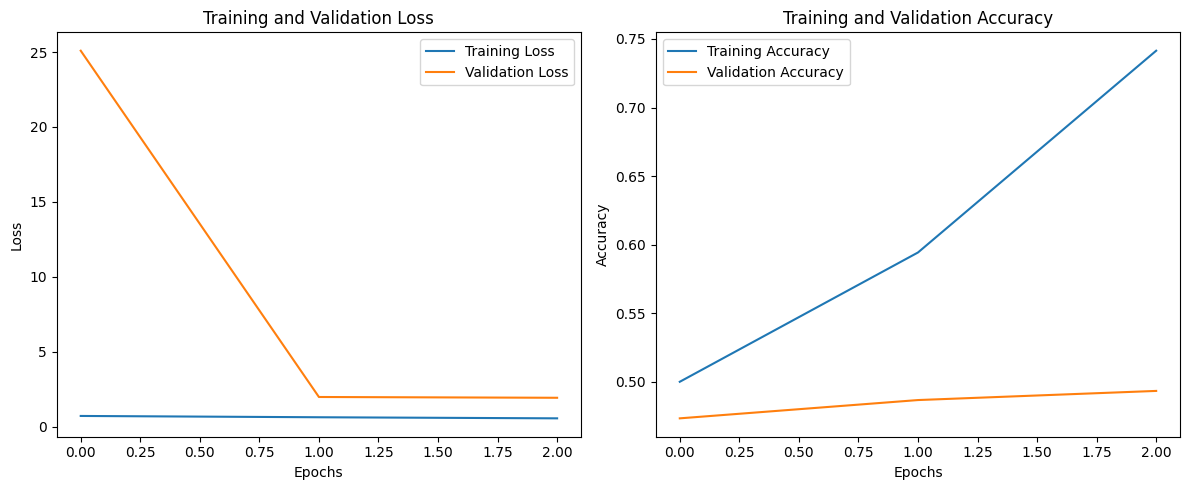

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step


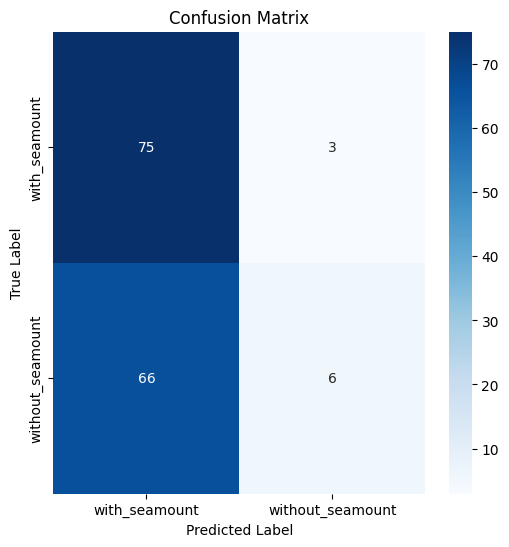

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 315ms/step


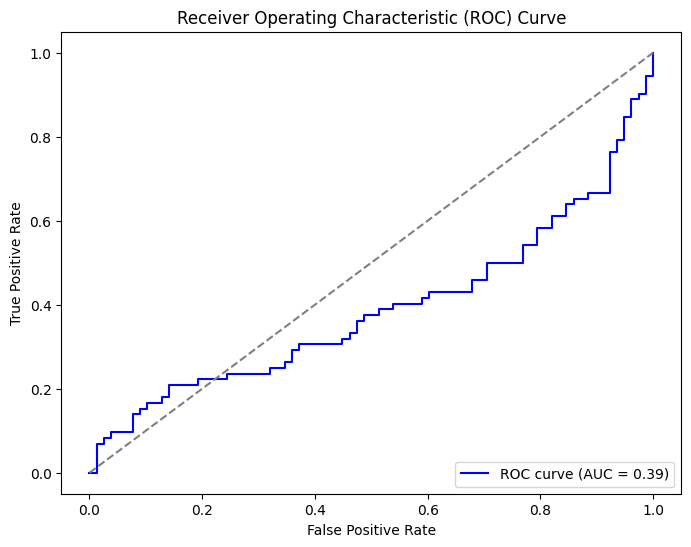

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 300ms/step
Classification Report:
                  precision    recall  f1-score   support

   with_seamount       0.53      0.96      0.68        78
without_seamount       0.67      0.08      0.15        72

        accuracy                           0.54       150
       macro avg       0.60      0.52      0.42       150
    weighted avg       0.60      0.54      0.43       150

Precision: 0.67
Recall: 0.08
F1 Score: 0.15


In [23]:
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Plotting the training/validation loss and accuracy
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Compute confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=config.CATEGORIES, yticklabels=config.CATEGORIES)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, model.predict(X_test).flatten())
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.show()

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype("int32").flatten()
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=config.CATEGORIES))

# Precision, Recall, F1-Score
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")


## Show some details about the non-matches

5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 307ms/step

--------------------------------------------------------------------------
Found 66 False Positive images - Displaying all
Predicted 'with_seamounts', but true label is 'without_seamounts' (False Positive)


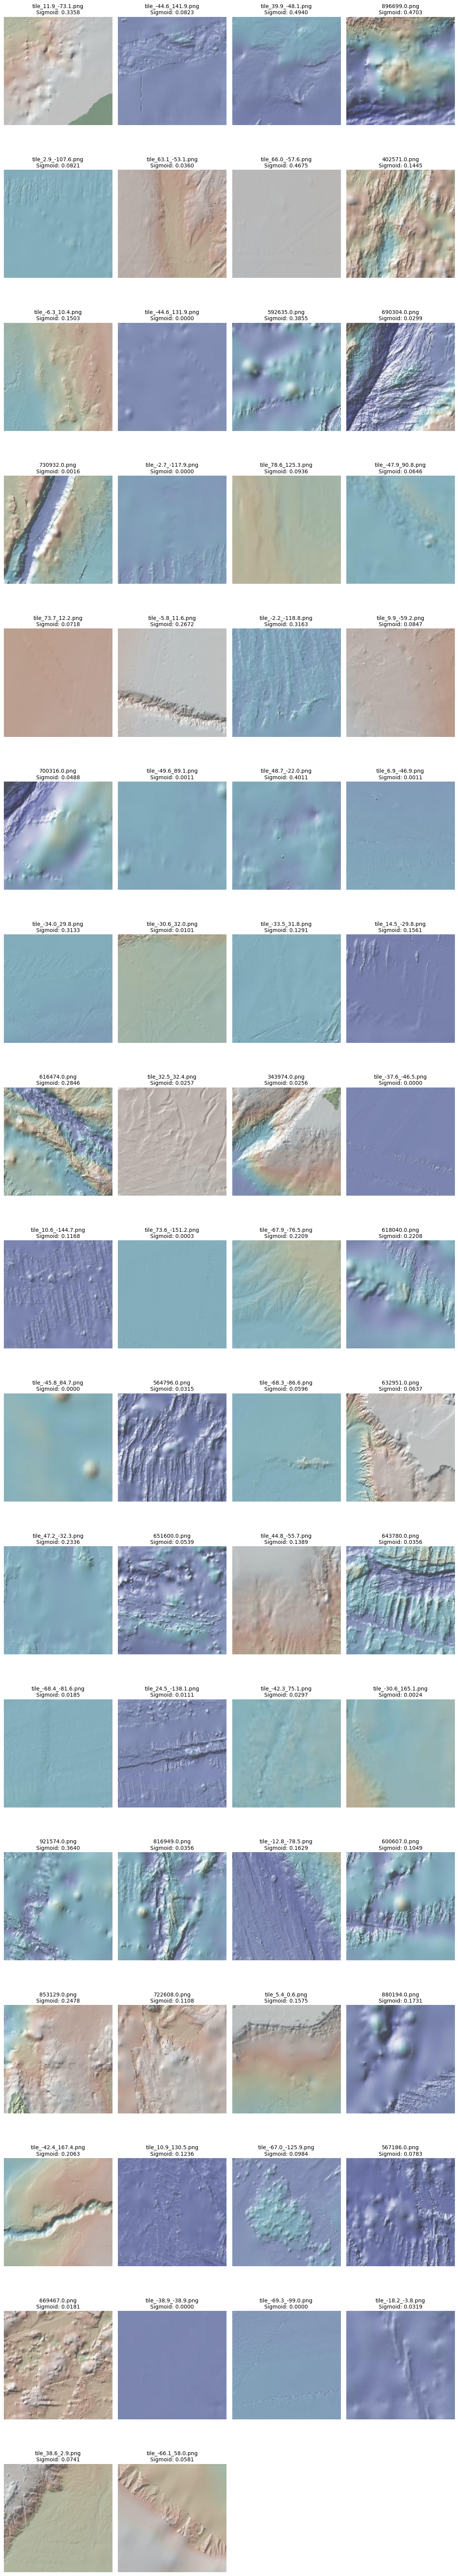


--------------------------------------------------------------------------
Found 3 False Negative images - Displaying all
Predicted 'without_seamounts', but true label is 'with_seamounts' (False Negative)


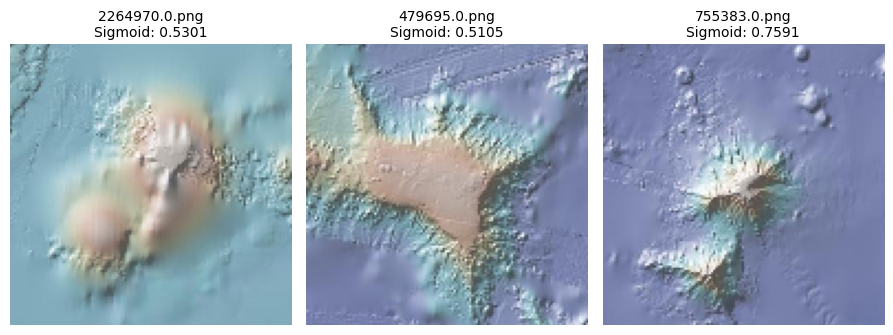

In [24]:
import matplotlib.pyplot as plt
import cv2
import math

# Get the indices of false positives and false negatives
false_positives = []
false_negatives = []

# calculate all predictions but keep sigmoid output value
y_pred_probs = model.predict(X_test).flatten() 

# Loop through the test set to find false positives and false negatives
for i in range(len(y_test)):
    
    if y_pred[i] == 0 and y_test[i] == 1:
        # Predicted 'with_seamounts', but true label is 'without_seamounts' (False Positive)  
        false_positives.append(i)
    elif y_pred[i] == 1 and y_test[i] == 0: 
        # Predicted 'without_seamounts', but true label is 'with_seamounts' (False Negative) 
        false_negatives.append(i)


# Display all False Positive images in a grid of 4 columns
num_images = len(false_positives)
columns = 4
rows = math.ceil(num_images / columns)

print(f"\n--------------------------------------------------------------------------")
print(f"Found {num_images} False Positive images - Displaying all")
print(f"Predicted 'with_seamounts', but true label is 'without_seamounts' (False Positive)")

plt.figure(figsize=(columns * 3, rows * 4))  # Adjust figure size for better visualization

for i, index in enumerate(false_positives):
    image = X_test[index] * 255.0  # Rescale back to original pixel values
    image = image.astype(np.uint8)

    plt.subplot(rows, columns, i + 1)  # Add subplot at the corresponding position
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Remove axes for a cleaner look

    # display more information to help interprete the image
    sigmoid_value =  y_pred_probs[index]
    image_name = filenames_test[index]
    plt.title(f"{image_name}\nSigmoid: {sigmoid_value:.4f}", fontsize=10, pad=5) 

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()

# Display all False Negative images in a grid of 4 columns
num_images = len(false_negatives)
columns = 4
rows = math.ceil(num_images / columns)

print(f"\n--------------------------------------------------------------------------")
print(f"Found {num_images} False Negative images - Displaying all")
print(f"Predicted 'without_seamounts', but true label is 'with_seamounts' (False Negative)")

plt.figure(figsize=(columns * 3, rows * 4))  # Adjust figure size for better visualization

for i, index in enumerate(false_negatives):
    image = X_test[index] * 255.0  # Rescale back to original pixel values
    image = image.astype(np.uint8)

    plt.subplot(rows, columns, i + 1)  # Add subplot at the corresponding position
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')  # Remove axes for a cleaner look

    # display more information to help interprete the image
    sigmoid_value =  y_pred_probs[index]
    image_name = filenames_test[index]
    plt.title(f"{image_name}\nSigmoid: {sigmoid_value:.4f}", fontsize=10, pad=5)

plt.tight_layout()  # Adjust layout to avoid overlapping
plt.show()